In [1]:
from IPython.display import HTML
HTML('''
<style>
.prompt {
  display: none;
}
</style>
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('notebook');
import warnings
warnings.filterwarnings('ignore')
data_538 = pd.read_csv("./data/hate_crimes.csv")
off_by_bias_motivation = pd.read_csv("./data/table_1_incidents_offenses_victims_and_known_offenders_by_bias_motivation_2016.csv")
off_by_off_type = pd.read_csv("./data/table_2_incidents_offenses_victims_and_known_offenders_by_offense_type_2016.csv")
off_race_by_off_type = pd.read_csv("./data/table_3_offenses_known_offenders_race_and_ethnicity_by_offense_type_2016.csv")
off_type_by_bias_motivation = pd.read_csv("./data/table_4_offenses_offense_type_by_bias_motivation_2016.csv")
off_race_by_bias_motivation = pd.read_csv("./data/table_5_offenses_known_offenders_race_and_ethnicity_by_bias_motivation_2016.csv")
off_by_state = pd.read_csv("./data/table_11_offenses_offense_type_by_participating_state_2016.csv")
locations = pd.read_csv("./data/table_10_incidents_bias_motivation_by_location_2016.csv")

[Problem Overview](index.html) | Exploratory Data Analysis | [Modeling Analysis](modeling_analysis.html) | [Conclusion](conclusion.html)
# Exploratory Data Analysis
Exploration questions - how many crimes per state
High-level insights, trends, outliers, etc.


## Comparing hate crime estimates

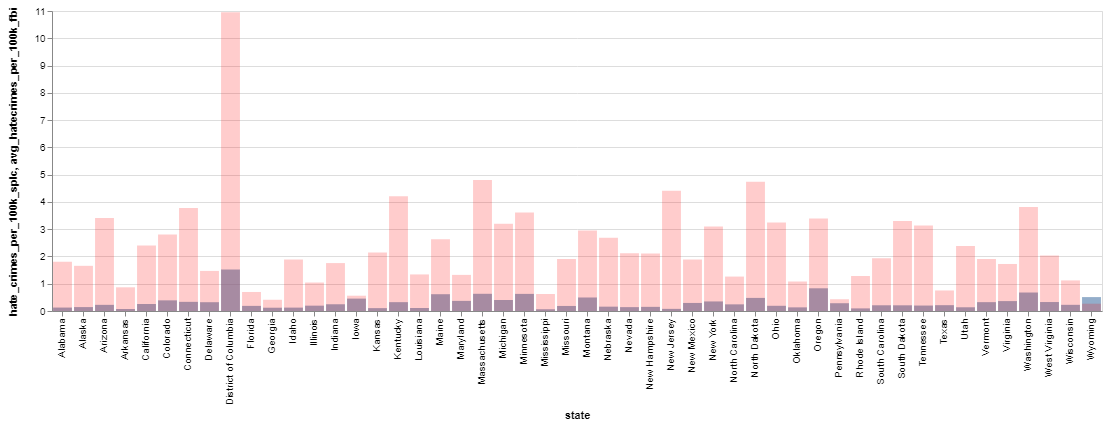

In [3]:
splc = alt.Chart(data_538).mark_bar(opacity = 0.6).encode(x = 'state', y = 'hate_crimes_per_100k_splc:Q')
fbi = alt.Chart(data_538).mark_bar(opacity = 0.2, color = 'red').encode(x = 'state', y = 'avg_hatecrimes_per_100k_fbi:Q')
splc+fbi

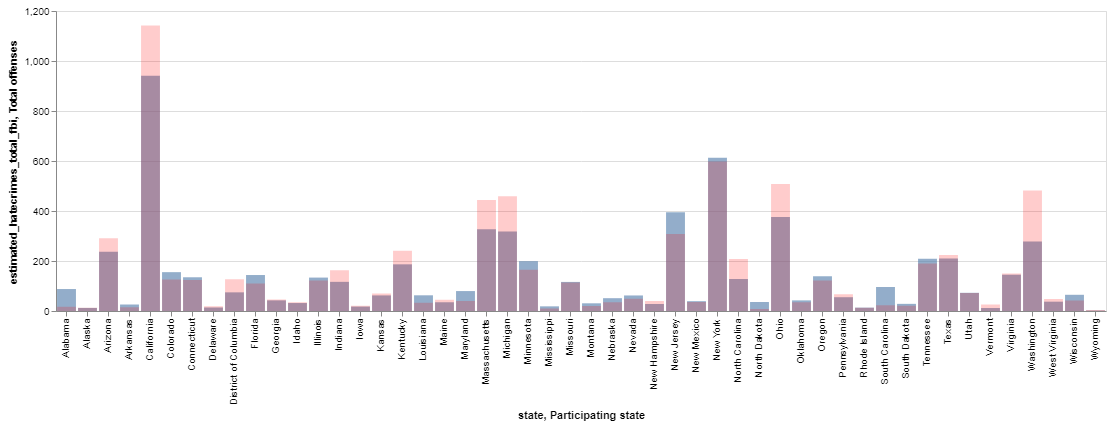

In [4]:
populations = pd.read_csv("./data/estimated_population_2016.csv")

data_538['population_2016'] = populations['population']


def newrow():
    for x in range(0, len(data_538.index)):
        data_538['estimated_hatecrimes_total'][x] = float(data_538['avg_hatecrimes_per_100k_fbi'][x]) * (data_538['population_2016'][x] / 1000000)

#new_time = dfs['XYF']['TimeUS'].astype(float)


data_538['population_2016'] = data_538['population_2016'].astype(float)
data_538['avg_hatecrimes_per_100k_fbi'] = data_538['avg_hatecrimes_per_100k_fbi'].astype(float)

data_538['estimated_hatecrimes_total_fbi'] = (data_538.population_2016 / 100000) * (data_538.avg_hatecrimes_per_100k_fbi)

estimated = alt.Chart(data_538).mark_bar(opacity = 0.6).encode(x = 'state', y = 'estimated_hatecrimes_total_fbi:Q')

offenses = alt.Chart(off_by_state[:50]).mark_bar(opacity = 0.2, color = 'red').encode(x='Participating state', y = 'Total offenses:Q')

estimated + offenses

This bar chart shows two measures of estimated hate crimes from the data. The red bars represent the `Total offenses` column from table 11 of the FBI data. The blue bars represent a calculated `estimated hate crimes` value, found by multiplying the `avg_hatecrimes_per_100k_fbi` by the state's `population / 100000`.



## Offenses by bias motivation

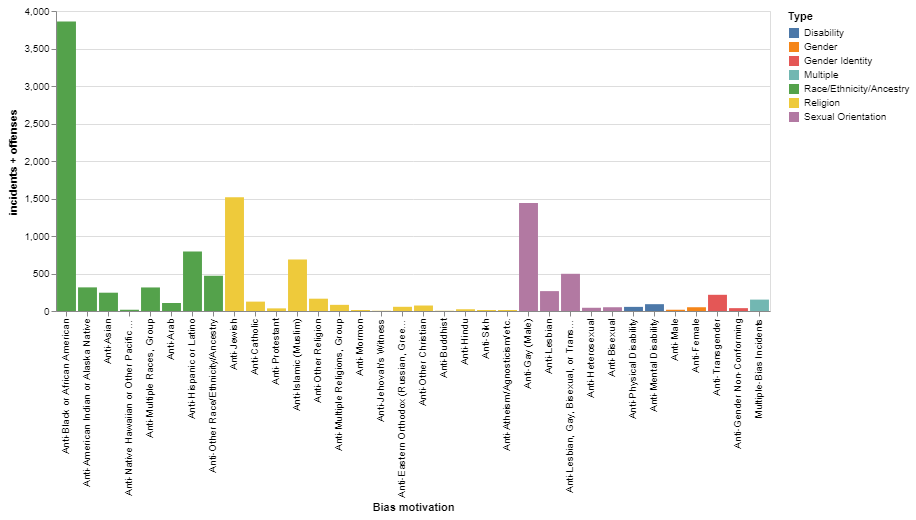

In [5]:
off_by_bias = off_by_bias_motivation.iloc[1:35,::]

off_by_bias['incidents + offenses'] = off_by_bias['Incidents'] + off_by_bias['Offenses']

incidents = alt.Chart(off_by_bias).mark_bar().encode(
    alt.X('Bias motivation', sort = ['Anti-Black or African American',
       'Anti-American Indian or Alaska Native', 'Anti-Asian',
       'Anti-Native Hawaiian or Other Pacific Islander',
       'Anti-Multiple Races, Group', 'Anti-Arab',
       'Anti-Hispanic or Latino', 'Anti-Other Race/Ethnicity/Ancestry',
       'Anti-Jewish', 'Anti-Catholic', 'Anti-Protestant',
       'Anti-Islamic (Muslim)', 'Anti-Other Religion',
       'Anti-Multiple Religions, Group', 'Anti-Mormon',
       "Anti-Jehovah's Witness",
       'Anti-Eastern Orthodox (Russian, Greek, Other)',
       'Anti-Other Christian', 'Anti-Buddhist', 'Anti-Hindu', 'Anti-Sikh',
       'Anti-Atheism/Agnosticism/etc.', 'Anti-Gay (Male)', 'Anti-Lesbian',
       'Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group)',
       'Anti-Heterosexual', 'Anti-Bisexual', 'Anti-Physical Disability',
       'Anti-Mental Disability', 'Anti-Male', 'Anti-Female',
       'Anti-Transgender', 'Anti-Gender Non-Conforming',
       'Multiple-Bias Incidents']),
    alt.Y('incidents + offenses'),
    color='Type',
)
incidents




The first chart aims to look at the frequency of hate incidents for each bias-motivation that were reported in 2016. The bars are colored corresponding to their more general categories, such as Anti Black and Anti Arab being colored green since they correspond to "Race/Ethnicity/Ancestry".

From this chart, it is immediatly clear that Anti-Black or African American motivated incidents have the highest frequency at around 3900. This doubles the frequencies of both Anti-Jewish and Anti-Gay (Male) motivated incidents, which are both respectively, the most frequent attacks for the Religion and Sexual Orientation categories.

[Previous FBI results](https://www.nbcnews.com/news/nbcblk/every-tally-hate-crimes-blacks-are-most-frequent-victims-n938541) paint a similar picture, with African Americans being targeted more than any other minority group, a fact that is in line with the US's treatment of African Americans, from slavery to the current political climate where white nationalism has become mainstream.

Noteably, the biases that motivated the least hate incidents are Anti-Native Hawaaiin, Anti-Mormon, Anti-Jehovah's Witness, Anti-Buddhist and Anti-Male. It's important to note that although Anti-Native Hawaiian motivated hate crimes rank low via this chart, the original FBI data frame does not include hate crame data from Hawaii, as it is the one state which does not take part in the annual report. It would be interesting and potentially enlightening for future studies to consult data on Hawaii's hate crimes, for there is much left uncovered.

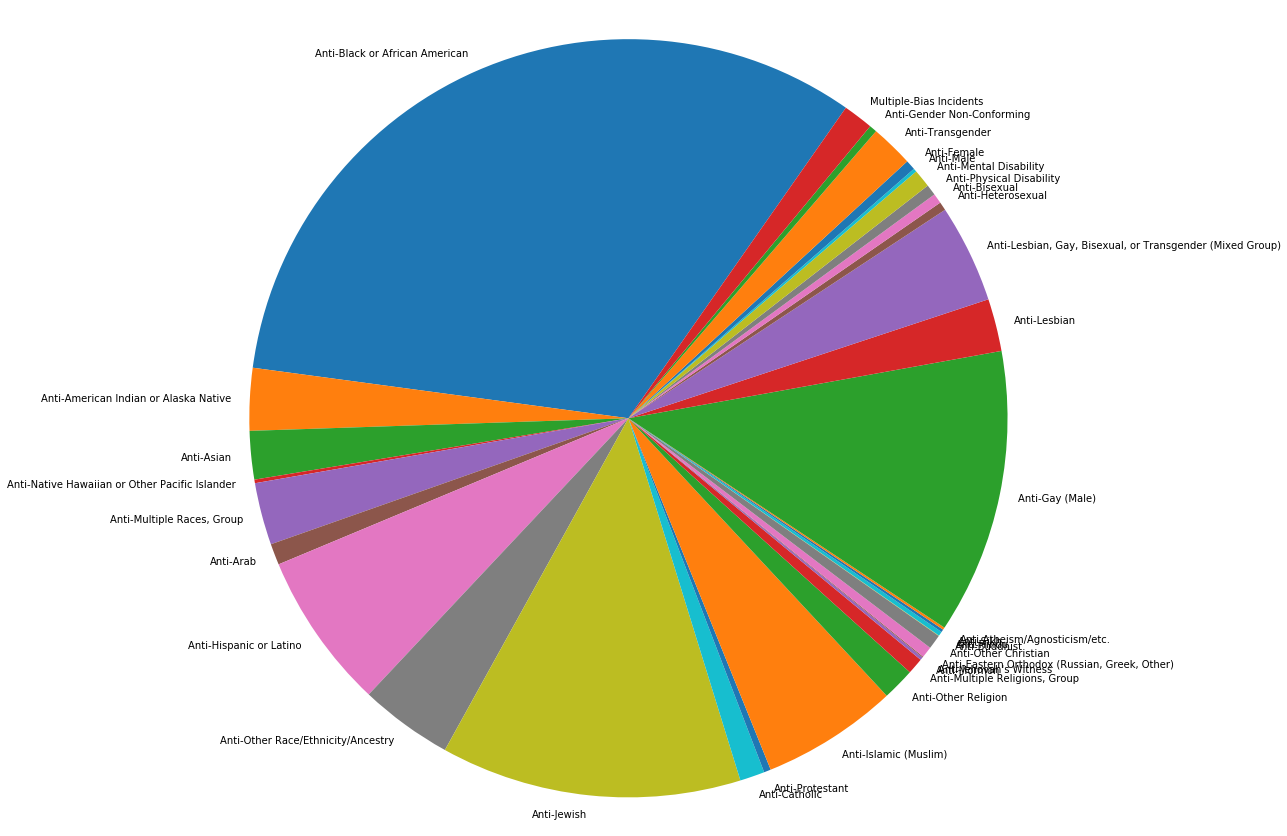

In [6]:
plt.figure(figsize=(15, 15))
plt.pie(x=off_by_bias['incidents + offenses'],startangle=55, labels = off_by_bias['Bias motivation'], labeldistance=1.05);
plt.axis('equal');

The pie chart is a different visualization of the same data as detailed above. The benefit of the pie chart as compared to the previous bar chart is its ability to approximate that Anti-Black motivated hate incidents' encompass about a third of all hate incidents in the US as reported in 2016. 

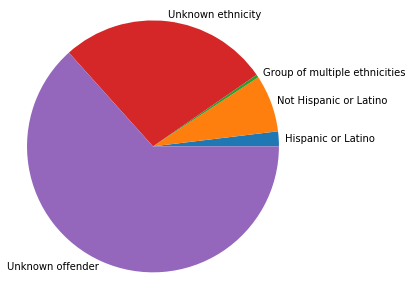

In [7]:
ethnicities = off_race_by_off_type[['Offense type', 'Hispanic or Latino',
       'Not Hispanic or Latino', 'Group of multiple ethnicities',
       'Unknown ethnicity', 'Unknown offender']]

races = off_race_by_off_type[['Offense type', 'White', 'Black or African\nAmerican', 'American Indian or Alaska Native', 'Asian', 'Native Hawaiian or Other Pacific Islander', 'Group of multiple races', 'Unknown race', 'Unknown offender']]


hi = ethnicities.T


ho = races.T


plt.figure(figsize=(5, 5))
plt.pie(x=hi[17][1:8].astype(int),startangle=0, labels = hi.index[1:8], labeldistance=1.05);
plt.axis('equal');



The next pie chart shows the proportion of offenses as committed by each ethnicity, a total of 5 which include (in order of highhest proportion):
- Unknown offender
- Unknown ethnicity
- Not Hispanic or Latino
- Hispanic or Latino
- Group of multiple ethnicities

The Unknown Offender slice takes up approximately 2/3 of the pie chart, meaning 2/3 of reported hate crimes do not have any data on the offender. The Unknown Ethnicity slice, meaning some aspect of the offender was identified but not their ethnicity, has the second highest freqency, affirming that most hate crime offenders do not have a reported ethnicity.

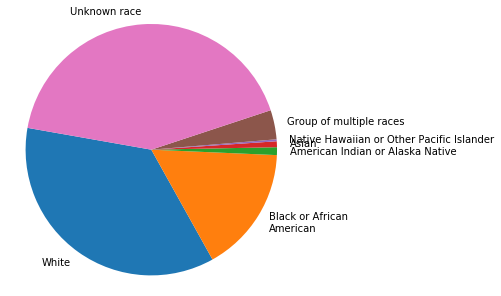

In [8]:
plt.figure(figsize=(5, 5))
plt.pie(x=ho[17][1:8].astype(int),startangle=170, labels = ho.index[1:8], labeldistance=1.1);
plt.axis('equal');

Although the offenders' ethnicities are mostly hidden from the dataset, the offenders' reported race is slightly more comprehensive, as shown in the next pie chart.

In this pie chart, the Unknown Race slice takes up almost half of the chart, though is followed by the white race, taking up about 1/3 of the pie. Black or African American make up the third largest chunk.

## Hate crimes per 100k people by median household income

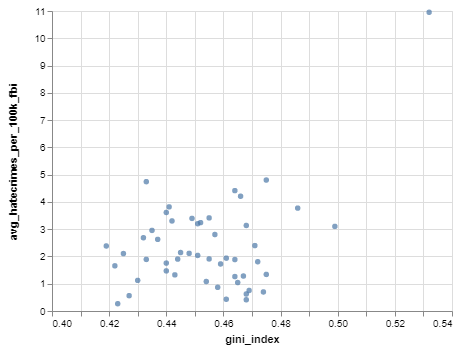

In [9]:
bymedian = alt.Chart(data_538).mark_circle().encode(alt.X('gini_index:Q', scale=alt.Scale(domain=[0.4, 0.54])), alt.Y('avg_hatecrimes_per_100k_fbi:Q'))
bymedian


The gini_index scatterplot aims to discover the relationship between each state's gini index and the average hatecrimms per 100k for each state. This data comes from FiveThirtyEight's hate crime GitHub page, which was used in their article discussing the impact of income inequality on hate crimes.

The Gini Index is a measure of economic inequality, with a value of 0 representing perfect equality and a measure of 1 representing representing extreme inequality (one person holding all the wealth in a community).

The article explains that community's with highher rates of income inequality have higher rates of hate crimes, supposing that the crimes are motivated by resentment towards minorities who the offender percieves to be doing better than them.

The scatterplot shows that the gini index and hate crames are not correlated. There is also a noteable outlier with a high gini index (~0.53) and high hate crime rate (comparatively higher than other states) of 11 per 100k people. This state is the District of Columbia. This may be due to the districts small population or better reporting standards.

It's important to note that although the gini-index is one measure of income inequality, it is not the only measure. In fact, the same data frame from which the gini index was taken, also includes features such as median household income which we created a scatterplot for below.

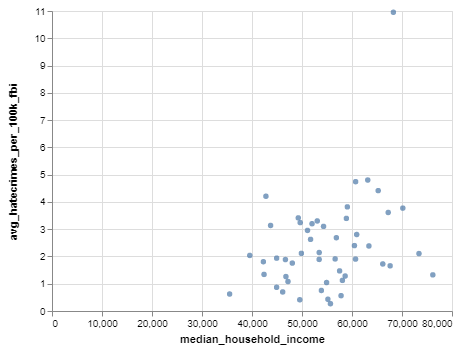

In [10]:
bystate = alt.Chart(data_538).mark_circle().encode(x = 'median_household_income:Q', y = 'avg_hatecrimes_per_100k_fbi:Q')

bystate

The results of the scatterplot shows a higher, positive correlation than the gini-index, again with a noteable outlier. The same outlier (11 hatecrimes per 100k) has a median income of just under $70,000. This state is Washington DC. 

The higher a state's median household income, the higher the average hate crime rate.

In our statistical modeling section, we combine the two features (gini index and median household income) along with other features of income inequality in predicting a state's hate crime incididences. 

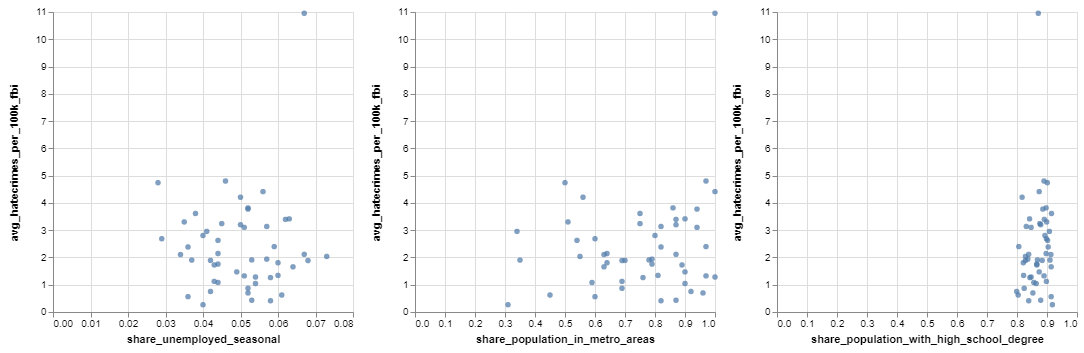

In [11]:
alt.Chart(data_538).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
).properties(
    width=300,
    height=300
).repeat(
    row=['avg_hatecrimes_per_100k_fbi'],
    column=['share_unemployed_seasonal',
       'share_population_in_metro_areas',
       'share_population_with_high_school_degree']
)

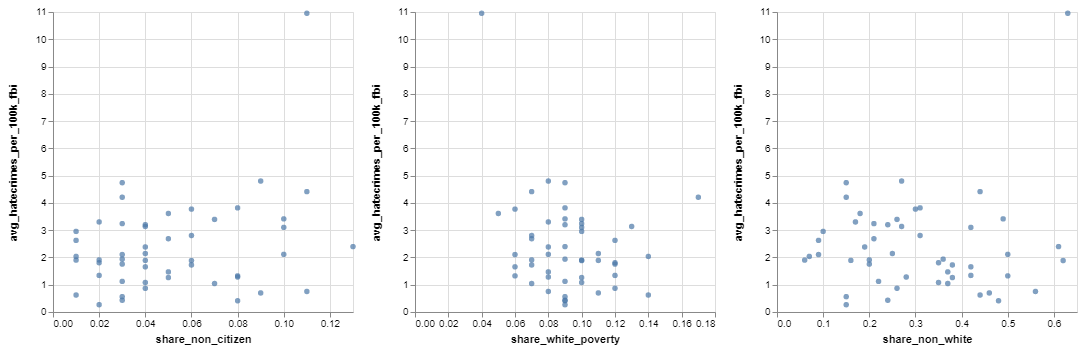

In [12]:
alt.Chart(data_538).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
).properties(
    width=300,
    height=300
).repeat(
    row=['avg_hatecrimes_per_100k_fbi'],
    column=['share_non_citizen',
       'share_white_poverty', 'share_non_white']
)


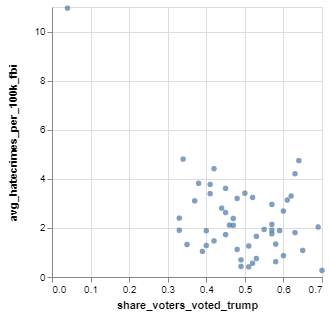

In [23]:
alt.Chart(data_538).mark_circle().encode(x = 'share_voters_voted_trump:Q', y='avg_hatecrimes_per_100k_fbi:Q').properties(width=270, height=270)




In [14]:
import plotly.plotly as py
import pandas as pd
import plotly

plotly.tools.set_credentials_file(username='caseyahlan', api_key='0WpK0XNGz71YCokMFYqB')

for col in data_538.columns:
    data_538[col] = data_538[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data_538['text'] = data_538['state'] + '<br>' +\
    'Average per 100k people: '+data_538['avg_hatecrimes_per_100k_fbi']

data = [ dict(
        type='choropleth',
        colorscale =  scl,
        autocolorscale = False,
        locations = data_538['code'],
        z = data_538['avg_hatecrimes_per_100k_fbi'].astype(float),
        locationmode = 'USA-states',
        text = data_538['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "Hate Crimes per 100k"
        )
    ) ]

layout = dict(
        title = 'Hate crimes per 100k people',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = dict( data=data, layout=layout )

py.iplot( fig, filename='fbi' )

In [15]:
plotly.tools.set_credentials_file(username='caseyahlan', api_key='0WpK0XNGz71YCokMFYqB')

for col in off_by_state.columns:
    off_by_state[col] = off_by_state[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

off_by_state['text'] = off_by_state['Participating state'] + '<br>' +\
    'total offenses: '+ off_by_state['Total offenses']

data = [ dict(
        type='choropleth',
        colorscale =  scl,
        autocolorscale = False,
        locations = off_by_state['code'][:51],
        z = off_by_state['Total offenses'][:51].astype(float),
        locationmode = 'USA-states',
        text = off_by_state['text'][:51],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "Hate Crimes in 2016"
        )
    ) ]

layout = dict(
        title = 'Total hate crime offenses in 2016',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = dict( data=data, layout=layout )

py.iplot( fig, filename='total offenses' )

### [Continue to Modeling Analysis](modeling_analysis.html)